In [1]:
import h5py
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load y labels
with h5py.File('data\\test_unit_13_30.h5', 'r') as f: 
    y_test13 = f['y'][:]
with h5py.File('data\\test_unit_14_30.h5', 'r') as f: 
    y_test14 = f['y'][:]
with h5py.File('data\\test_unit_15_30.h5', 'r') as f: 
    y_test15 = f['y'][:]

# Load health state features
with h5py.File('data\\hs_x_test_13_conv.h5', 'r') as f:
    hs_x_test13_conv = f['test13'][:]
with h5py.File('data\\hs_x_test_14_conv.h5', 'r') as f:
    hs_x_test14_conv = f['test14'][:]
with h5py.File('data\\hs_x_test_15_conv.h5', 'r') as f:
    hs_x_test15_conv = f['test15'][:]

# Load RUL features
with h5py.File('data\\rul_x_test_13_conv.h5', 'r') as f:
    rul_x_test13_conv = f['test13'][:]
with h5py.File('data\\rul_x_test_14_conv.h5', 'r') as f:
    rul_x_test14_conv = f['test14'][:]
with h5py.File('data\\rul_x_test_15_conv.h5', 'r') as f:
    rul_x_test15_conv = f['test15'][:]

In [3]:
# Load Models
hs_cb_model = CatBoostClassifier()
hs_cb_model.load_model('hs_cb_model.cbm')
rul_cb_model = CatBoostRegressor()
rul_cb_model.load_model('rul_cb_model.cbm')

In [4]:
# Get Training Metrics
print("CatBoost Classifier Model Summary:")
print(hs_cb_model.get_all_params())
print("\nCatBoost Regressor Model Summary:")
print(rul_cb_model.get_all_params())

print("\nCatBoost Classifier Metrics:")
print("Accuracy:", hs_cb_model.get_best_score())
print("Best Iteration:", hs_cb_model.get_best_iteration())

print("\nCatBoost Regressor Metrics:")
print("RMSE:", rul_cb_model.get_best_score())
print("Best Iteration:", rul_cb_model.get_best_iteration())


CatBoost Classifier Model Summary:
{'nan_mode': 'Min', 'eval_metric': 'Accuracy', 'iterations': 2000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.1000000015, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.8000000119, 'use_best_model': True, 'od_wait': 50, 'class_names': [0, 1], 'random_seed': 42, 'depth': 10, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shri

In [92]:
# Separate RUL and Health State
y_rul_test13 = y_test13[:, 0]
y_health_test13 = y_test13[:, 1]

y_rul_test14 = y_test14[:, 0]
y_health_test14 = y_test14[:, 1]

y_rul_test15 = y_test15[:, 0]
y_health_test15 = y_test15[:, 1]

In [93]:
# Predict health states
health_predictions_cb = hs_cb_model.predict(hs_x_test13_conv)
health_pred_classes_cb = (health_predictions_cb > 0.5).astype(int).reshape(-1)
health_predictions_cb2 = hs_cb_model.predict(hs_x_test14_conv)
health_pred_classes_cb2 = (health_predictions_cb2 > 0.5).astype(int).reshape(-1)
health_predictions_cb3 = hs_cb_model.predict(hs_x_test15_conv)
health_pred_classes_cb3 = (health_predictions_cb3 > 0.5).astype(int).reshape(-1)

# Predict RUL
rul_predictions_cb = rul_cb_model.predict(rul_x_test13_conv)
rul_pred_classes_cb = rul_predictions_cb.reshape(-1)
rul_predictions_cb2 = rul_cb_model.predict(rul_x_test14_conv)
rul_pred_classes_cb2 = rul_predictions_cb2.reshape(-1)
rul_predictions_cb3 = rul_cb_model.predict(rul_x_test15_conv)
rul_pred_classes_cb3 = rul_predictions_cb3.reshape(-1)

In [94]:

def running_weighted_average(data, window_size=1500):
    """
    Computes a running weighted average of the input data using a specified window size.

    Parameters:
    data (array-like): The input data for which the running weighted average is to be calculated.
    window_size (int): The size of the window for the weighted average.

    Returns:
    np.array: An array containing the running weighted averages.
    """
    weights = np.arange(1, window_size + 1)  # Create weights from 1 to window_size
    weighted_averages = np.zeros(len(data))

    for i in range(len(data)):
        if i < window_size:
            weighted_averages[i] = np.sum(weights[:i + 1] * data[:i + 1]) / np.sum(weights[:i + 1])
        else:
            weighted_averages[i] = np.sum(weights * data[i - window_size + 1:i + 1]) / np.sum(weights)

    return weighted_averages

# Calculate Running Weighted Averages
rul_pred_avg13 = running_weighted_average(rul_pred_classes_cb)
rul_pred_avg14 = running_weighted_average(rul_pred_classes_cb2)
rul_pred_avg15 = running_weighted_average(rul_pred_classes_cb3)

health_pred_avg13 = (running_weighted_average(health_pred_classes_cb) > 0.5).astype(int)
health_pred_avg14 = (running_weighted_average(health_pred_classes_cb2) > 0.5).astype(int)
health_pred_avg15 = (running_weighted_average(health_pred_classes_cb3) > 0.5).astype(int)

In [95]:
# Calculate accuracy
health_accuracy_cb = accuracy_score(y_health_test13, health_pred_classes_cb)
health_accuracy_cb2 = accuracy_score(y_health_test14, health_pred_classes_cb2)
health_accuracy_cb3 = accuracy_score(y_health_test15, health_pred_classes_cb3)

print(f"Test 13 Health State Accuracy: {health_accuracy_cb * 100:.2f}%")
print(f"Test 14 Health State Accuracy: {health_accuracy_cb2 * 100:.2f}%")
print(f"Test 15 Health State Accuracy: {health_accuracy_cb3 * 100:.2f}%")

health_accuracy_avg13 = accuracy_score(y_health_test13, health_pred_avg13)
health_accuracy_avg14 = accuracy_score(y_health_test14, health_pred_avg14)
health_accuracy_avg15 = accuracy_score(y_health_test15, health_pred_avg15)

print(f"Test 13 Health State Running Weighted Average Accuracy: {health_accuracy_avg13 * 100:.2f}%")
print(f"Test 14 Health State Running Weighted Average Accuracy: {health_accuracy_avg14 * 100:.2f}%")
print(f"Test 15 Health State Running Weighted Average Accuracy: {health_accuracy_avg15 * 100:.2f}%")

Test 13 Health State Accuracy: 93.31%
Test 14 Health State Accuracy: 93.04%
Test 15 Health State Accuracy: 95.80%
Test 13 Health State Running Weighted Average Accuracy: 97.00%
Test 14 Health State Running Weighted Average Accuracy: 98.96%
Test 15 Health State Running Weighted Average Accuracy: 99.56%


In [96]:
# Calculate RUL MAE
rul_accuracy_cb = mean_absolute_error(y_rul_test13, rul_pred_classes_cb)
rul_accuracy_cb2 = mean_absolute_error(y_rul_test14, rul_pred_classes_cb2)
rul_accuracy_cb3 = mean_absolute_error(y_rul_test15, rul_pred_classes_cb3)
print(f"Test 13 RUL MAE: {rul_accuracy_cb}")
print(f"Test 14 RUL MAE: {rul_accuracy_cb2}")
print(f"Test 15 RUL MAE: {rul_accuracy_cb3}")

rul_accuracy_avg13 = mean_absolute_error(y_rul_test13, rul_pred_avg13)
rul_accuracy_avg14 = mean_absolute_error(y_rul_test14, rul_pred_avg14)
rul_accuracy_avg15 = mean_absolute_error(y_rul_test15, rul_pred_avg15)
print(f"Test 13 Running Weighted Average RUL MAE: {rul_accuracy_avg13}")
print(f"Test 14 Running Weighted Average RUL MAE: {rul_accuracy_avg14}")
print(f"Test 15 Running Weighted Average RUL MAE: {rul_accuracy_avg15}")

Test 13 RUL MAE: 6.178516257238013
Test 14 RUL MAE: 3.7289807032740625
Test 15 RUL MAE: 2.552871838504306
Test 13 Running Weighted Average RUL MAE: 5.676581828596827
Test 14 Running Weighted Average RUL MAE: 3.4561442721510938
Test 15 Running Weighted Average RUL MAE: 1.8950747392072718


In [99]:
# Calculate RUL Root MSE
rul_accuracy_cb = root_mean_squared_error(y_rul_test13, rul_pred_classes_cb)
rul_accuracy_cb2 = root_mean_squared_error(y_rul_test14, rul_pred_classes_cb2)
rul_accuracy_cb3 = root_mean_squared_error(y_rul_test15, rul_pred_classes_cb3)
print(f"Test 13 RUL Root MSE: {rul_accuracy_cb}")
print(f"Test 14 RUL Root MSE: {rul_accuracy_cb2}")
print(f"Test 15 RUL Root MSE: {rul_accuracy_cb3}")

rul_accuracy_avg13 = root_mean_squared_error(y_rul_test13, rul_pred_avg13)
rul_accuracy_avg14 = root_mean_squared_error(y_rul_test14, rul_pred_avg14)
rul_accuracy_avg15 = root_mean_squared_error(y_rul_test15, rul_pred_avg15)
print(f"Test 13 Running Weighted Average RUL Root MSE: {rul_accuracy_avg13}")
print(f"Test 14 Running Weighted Average RUL Root MSE: {rul_accuracy_avg14}")
print(f"Test 15 Running Weighted Average RUL Root MSE: {rul_accuracy_avg15}")

Test 13 RUL Root MSE: 8.250174556155418
Test 14 RUL Root MSE: 5.420302029252609
Test 15 RUL Root MSE: 4.0702793271719235
Test 13 Running Weighted Average RUL Root MSE: 7.49595764349466
Test 14 Running Weighted Average RUL Root MSE: 4.481227884249215
Test 15 Running Weighted Average RUL Root MSE: 2.774002462001578


In [100]:
def custom_nasa_metric(real_values, estimated_values):
    """
    This function computes a metric that quantifies the difference between 
    actual and estimated RUL values by calculating the sum of the exponential 
    of the absolute differences scaled by a factor (alpha).

    Parameters:
    real_values (array-like): The actual RUL values.
    estimated_values (array-like): The predicted RUL values.

    Returns:
    float: The computed metric value.
    """
    real_values = np.array(real_values)
    estimated_values = np.array(estimated_values)

    # Compute differences
    delta = real_values - estimated_values

    # Set alpha value based on under or overestimation
    alpha = np.where(delta > 0, 1/13, 1/10)

    # Compute the metric
    s = np.mean(np.exp(alpha * np.abs(delta)))

    return s

result = custom_nasa_metric(y_rul_test13, rul_pred_classes_cb)
result2 = custom_nasa_metric(y_rul_test14, rul_pred_classes_cb2)
result3 = custom_nasa_metric(y_rul_test15, rul_pred_classes_cb3)

print("Test 13 RUL NASA Scoring Function:", result)
print("Test 14 RUL NASA Scoring Function:", result2)
print("Test 15 RUL NASA Scoring Function:", result3)

result_avg13 = custom_nasa_metric(y_rul_test13, rul_pred_avg13)
result_avg14 = custom_nasa_metric(y_rul_test14, rul_pred_avg14)
result_avg15 = custom_nasa_metric(y_rul_test15, rul_pred_avg15)

print("Test 13 Running Weighted Average RUL NASA Scoring Function:", result_avg13)
print("Test 14 Running Weighted Average RUL NASA Scoring Function:", result_avg14)
print("Test 15 Running Weighted Average RUL NASA Scoring Function:", result_avg15)

Test 13 RUL NASA Scoring Function: 1.7885262808674456
Test 14 RUL NASA Scoring Function: 1.545275304209536
Test 15 RUL NASA Scoring Function: 1.2941173532385364
Test 13 Running Weighted Average RUL NASA Scoring Function: 1.677077501460568
Test 14 Running Weighted Average RUL NASA Scoring Function: 1.4595174605096957
Test 15 Running Weighted Average RUL NASA Scoring Function: 1.1924294100734478


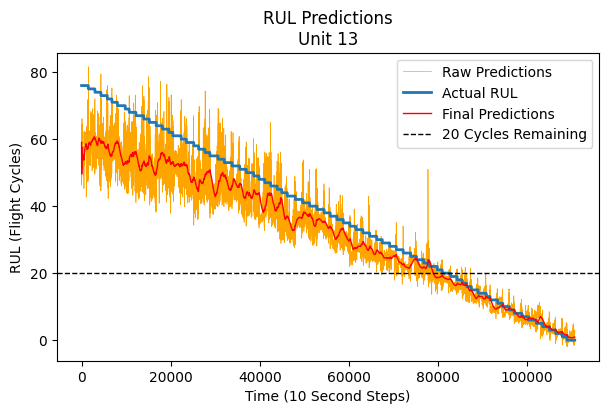

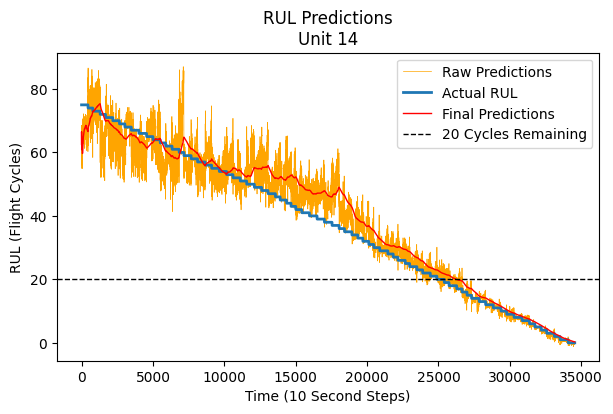

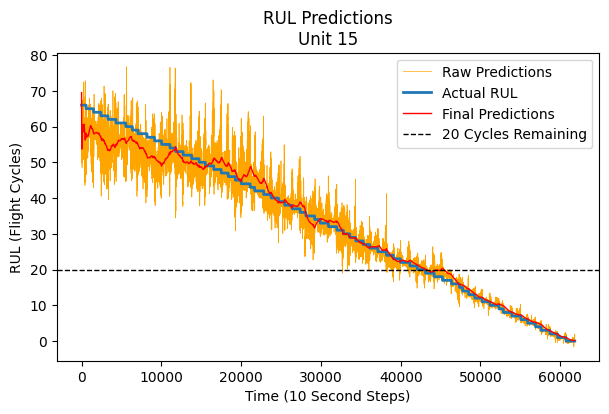

In [107]:
# Plot RUL Predictions
plt.figure(figsize=(7, 4))
plt.plot(rul_pred_classes_cb, label='Raw Predictions', linewidth=.5, color='orange')
plt.plot(y_rul_test13, label='Actual RUL', linewidth=2, color='tab:blue')
plt.plot(rul_pred_avg13, label='Final Predictions', linewidth=1, color='r')
plt.axhline(y=20, color='black', linestyle='--', linewidth=1, label='20 Cycles Remaining')
plt.xlabel('Time (10 Second Steps)')
plt.ylabel('RUL (Flight Cycles)')
plt.title('RUL Predictions\nUnit 13')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(rul_pred_classes_cb2, label='Raw Predictions', linewidth=.5, color='orange')
plt.plot(y_rul_test14, label='Actual RUL', linewidth=2, color='tab:blue')
plt.plot(rul_pred_avg14, label='Final Predictions', linewidth=1, color='r')
plt.axhline(y=20, color='black', linestyle='--', linewidth=1, label='20 Cycles Remaining')
plt.xlabel('Time (10 Second Steps)')
plt.ylabel('RUL (Flight Cycles)')
plt.title('RUL Predictions\nUnit 14')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(rul_pred_classes_cb3, label='Raw Predictions', linewidth=.5, color='orange')
plt.plot(y_rul_test15, label='Actual RUL', linewidth=2, color='tab:blue')
plt.plot(rul_pred_avg15, label='Final Predictions', linewidth=1, color='r')
plt.axhline(y=20, color='black', linestyle='--', linewidth=1, label='20 Cycles Remaining')
plt.xlabel('Time (10 Second Steps)')
plt.ylabel('RUL (Flight Cycles)')
plt.title('RUL Predictions\nUnit 15')
plt.legend()
plt.show()



In [102]:
def find_health_state_change(y_health):
    """
    This function finds the index where the health state changes from 1 to 0.
    
    Parameters:
    y_health (array-like): Array of health states (0s and 1s).
    
    Returns:
    int: Index of the first occurrence of the change from 1 to 0, or -1 if no change is found.
    """
    for i in range(1, len(y_health)):
        if y_health[i-1] == 1 and y_health[i] == 0:
            return i
    return -1

# Find Health State Change
change_index_test13 = find_health_state_change(y_health_test13)
change_index_test14 = find_health_state_change(y_health_test14)
change_index_test15 = find_health_state_change(y_health_test15)

print("Change index Test 13:", change_index_test13)
print("Change index Test 14:", change_index_test14)
print("Change index Test 15:", change_index_test15)


Change index Test 13: 25168
Change index Test 14: 15959
Change index Test 15: 21693


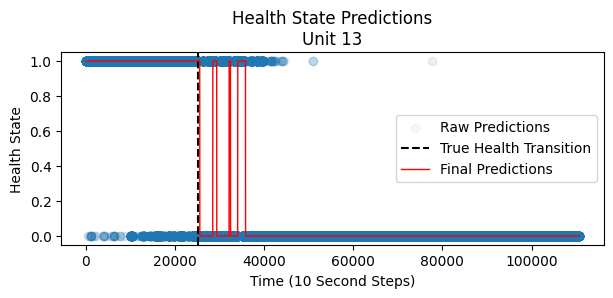

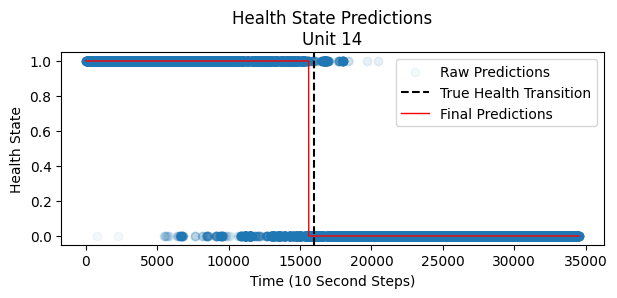

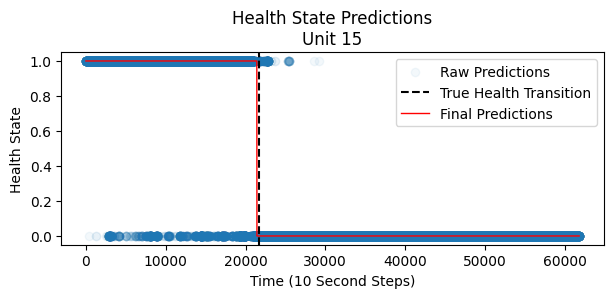

In [105]:
# Plot health state predictions
plt.figure(figsize=(7, 2.5))
plt.scatter(range(len(health_pred_classes_cb)), health_pred_classes_cb, label='Raw Predictions', alpha=0.05)
plt.axvline(x=change_index_test13, color='black', linestyle='--', label='True Health Transition')
plt.plot(health_pred_avg13, label='Final Predictions', linewidth=1, color='r')
plt.ylabel('Health State')
plt.xlabel('Time (10 Second Steps)')
plt.title('Health State Predictions\nUnit 13')
plt.legend()
plt.show()

plt.figure(figsize=(7, 2.5))
plt.scatter(range(len(health_pred_classes_cb2)), health_pred_classes_cb2, label='Raw Predictions', alpha=0.05)
plt.axvline(x=change_index_test14, color='black', linestyle='--', label='True Health Transition')
plt.plot(health_pred_avg14, label='Final Predictions', linewidth=1, color='r')
plt.ylabel('Health State')
plt.xlabel('Time (10 Second Steps)')
plt.title('Health State Predictions\nUnit 14')
plt.legend()
plt.show()

plt.figure(figsize=(7, 2.5))
plt.scatter(range(len(health_pred_classes_cb3)), health_pred_classes_cb3, label='Raw Predictions', alpha=0.05)
plt.axvline(x=change_index_test15, color='black', linestyle='--', label='True Health Transition')
plt.plot(health_pred_avg15, label='Final Predictions', linewidth=1, color='r')
plt.ylabel('Health State')
plt.xlabel('Time (10 Second Steps)')
plt.title('Health State Predictions\nUnit 15')
plt.legend()
plt.show()
